(-0.5, 27.5, 27.5, -0.5)

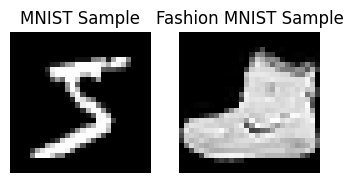

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformación de los datos (normalización entre 0 y 1)
transform = transforms.Compose([transforms.ToTensor()])

# Cargar datos de MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Cargar datos de Fashion MNIST
fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Crear DataLoaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=256, shuffle=False)

# Mostrar el primer dato de MNIST
mnist_sample, _ = mnist_train[0]
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("MNIST Sample")
plt.imshow(mnist_sample.squeeze(), cmap='gray')
plt.axis('off')

# Mostrar el primer dato de Fashion MNIST
fashion_mnist_sample, _ = fashion_mnist_train[0]
plt.subplot(1, 2, 2)
plt.title("Fashion MNIST Sample")
plt.imshow(fashion_mnist_sample.squeeze(), cmap='gray')
plt.axis('off')

#plt.show()

In [2]:
# Concatenar el primer ejemplo de Fashion MNIST con el conjunto de prueba de MNIST
mnist_test_data = torch.cat([mnist_test.data.float() , fashion_mnist_test.data[0].float().unsqueeze(0)])
x_test = mnist_test_data.view(-1, 784)  # Aplanar las imágenes
print("x_test shape:", x_test.shape)

# Definición del autoencoder en PyTorch
class Autoencoder(nn.Module):
    
    def __init__(self, feature_layer_dim=64):  
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, feature_layer_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(feature_layer_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
# Inicialización del modelo, función de pérdida y optimizador
model = Autoencoder(feature_layer_dim=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del autoencoder
num_epochs = 30
for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(data.size(0), -1)  # Aplanar las imágenes y normalizar
        output = model(data)
        loss = criterion(output, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



x_test shape: torch.Size([10001, 784])
Epoch [1/30], Loss: 0.0367
Epoch [2/30], Loss: 0.0249
Epoch [3/30], Loss: 0.0200
Epoch [4/30], Loss: 0.0167
Epoch [5/30], Loss: 0.0140
Epoch [6/30], Loss: 0.0134
Epoch [7/30], Loss: 0.0118
Epoch [8/30], Loss: 0.0130
Epoch [9/30], Loss: 0.0106
Epoch [10/30], Loss: 0.0111
Epoch [11/30], Loss: 0.0104
Epoch [12/30], Loss: 0.0102
Epoch [13/30], Loss: 0.0091
Epoch [14/30], Loss: 0.0093
Epoch [15/30], Loss: 0.0086
Epoch [16/30], Loss: 0.0079
Epoch [17/30], Loss: 0.0072
Epoch [18/30], Loss: 0.0074
Epoch [19/30], Loss: 0.0081
Epoch [20/30], Loss: 0.0062
Epoch [21/30], Loss: 0.0076
Epoch [22/30], Loss: 0.0069
Epoch [23/30], Loss: 0.0062
Epoch [24/30], Loss: 0.0070
Epoch [25/30], Loss: 0.0070
Epoch [26/30], Loss: 0.0068
Epoch [27/30], Loss: 0.0076
Epoch [28/30], Loss: 0.0063
Epoch [29/30], Loss: 0.0065
Epoch [30/30], Loss: 0.0059


Error de reconstrucción del zapato: 6472.1875
Mayores errores de reconstrucción:
[19864.373 19482.293 18732.785 18668.414 18502.422]


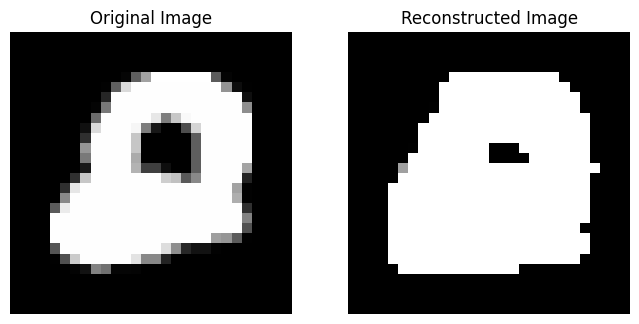

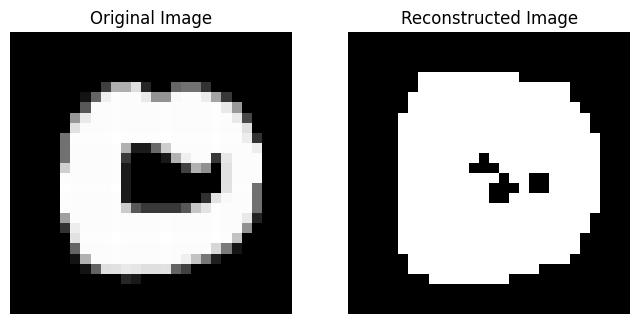

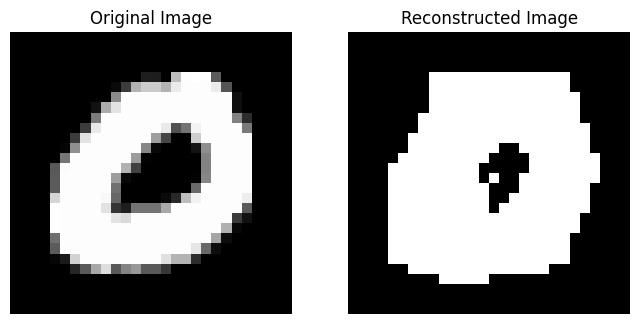

In [3]:
mnist_test_data = mnist_test.data.float()  
y_test = mnist_test_data.view(-1, 784) #prueba sin anomalia

# Reconstrucción de las imágenes en el conjunto de prueba con x_test
with torch.no_grad():
    reconstructed = model(x_test)



# Mostrar las imágenes originales y reconstruidas con los errores más altos
reconstruction_errors = ((x_test - reconstructed) ** 2).mean(dim=1)
sorted_errors, indices = torch.sort(reconstruction_errors, descending=True)

zapato_error = reconstruction_errors[-1].item()  # Último índice es el zapato
print(f"Error de reconstrucción del zapato: {zapato_error}")

# Mostrar la imagen del zapato
#print("imagen del zapato concatenada:")
#fig = plt.figure(figsize=(4, 4))
#plt.title("Imagen del zapato original")
#plt.imshow(x_test[-1].view(28, 28).cpu(), cmap='gray')  # Última imagen en el conjunto concatenado
#plt.axis('off')
#plt.show()

# Imprimir los 5 mayores errores
print("Mayores errores de reconstrucción:")
print(sorted_errors[:5].cpu().numpy())


# Visualizar las  imágenes con los errores más altos
for i in range(3):
    idx = indices[i].item()
    
    fig = plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(x_test[idx].view(28, 28).cpu(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed[idx].view(28, 28).cpu(), cmap='gray')
    plt.axis('off')
    plt.show()